<a href="https://colab.research.google.com/github/priya456-hash/Thesis/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing required libraries

import os
import re
import glob
import pathlib
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile 
import heapq
import matplotlib.image as mpimg
import tensorflow as tf 
from scipy.stats import pearsonr
from tensorflow.keras import layers 
from tensorflow.keras import models 
from tensorflow.keras import Model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

import cv2

import PIL
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

SEED=123
np.random.seed(SEED)



In [ ]:
# Loading tensorflow 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
CFG = dict(
        batch_size        =  16,     # 8; 16; 32; 64; bigger batch size leads to memory allocation issues. 
        epochs            =  100,   # 5; 10; 20;
        verbose           =   0,    # 0; 1
        workers           =   2,    # 1; 2; 3

        optimizer         = 'adam', # 'SGD', 'RMSprop'

        RANDOM_STATE      =  123,   
    
        # Path to save a model
        path_model        = '../working/',

        # Images sizes
        img_size          = 224, 
        img_height        = 224, 
        img_width         = 224, 

        # Images augs
        ROTATION          = 180.0,
        ZOOM              =  10.0,
        ZOOM_RANGE        =  [0.9,1.1],
        HZOOM             =  10.0,
        WZOOM             =  10.0,
        HSHIFT            =  10.0,
        WSHIFT            =  10.0,
        SHEAR             =   5.0,
        HFLIP             = True,
        VFLIP             = True,

        # Postprocessing
        label_smooth_fac  =  0.00,  # 0.01; 0.05; 0.1; 0.2;    
)



In [ ]:
# Unzip all files to same directory of zip file
zip_file = '/content/Bone_parts.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Create a test, train and validation directories
dir = '/content/Bone_parts'
train_dir = os.path.join(dir, 'train')
validation_dir = os.path.join(dir, 'validation')
test_dir = os.path.join(dir, 'test')

# Biomaterial Directories
train_Biomaterial_dir = os.path.join(train_dir, 'biomaterial')
test_Biomaterial_dir = os.path.join(test_dir, 'biomaterial')

# bone_marrow Directories
train_bone_marrow_dir = os.path.join(train_dir, 'bone_marrow')
test_bone_marrow_dir = os.path.join(test_dir, 'bone_marrow')

#bone_with_osteocytes directories
train_bone_with_osteocytes_dir = os.path.join(train_dir, 'bone_with_osteocytes')
test_bone_with_osteocytes_dir = os.path.join(test_dir, 'bone_with_osteocytes')

#bone_without_osteocytes
train_bone_without_osteocytes_dir = os.path.join(train_dir, 'bone_without_osteocytes')
test_bone_without_osteocytes_dir = os.path.join(test_dir, 'bone_without_osteocytes')


# tissue_fibrous
train_tissue_fibrous_dir = os.path.join(train_dir, 'tissue_fibrous')
test_tissue_fibrous_dir = os.path.join(test_dir, 'tissue_fibrous')

print(train_tissue_fibrous_dir)


In [ ]:
# Plot a sample image

#create list for all images
images = []
names = []

#Get first image of tissue_fibrous
train_tissue_fibrous_filenames = os.listdir(train_tissue_fibrous_dir)

#Plot the first image
images.append(mpimg.imread(train_tissue_fibrous_dir + "/" + train_tissue_fibrous_filenames[0]))
names.append("tissue_fibrous")

#Get first image of biomaterial
train_Biomaterial_filenames = os.listdir(train_Biomaterial_dir)

#Plot the first image
images.append(mpimg.imread(train_Biomaterial_dir + "/" + train_Biomaterial_filenames[0]))
names.append("biomaterial")

#Get first image of bone marrow
train_bone_marrow_filenames = os.listdir(train_bone_marrow_dir)

#Plot the first image
images.append(mpimg.imread(train_bone_marrow_dir + "/" + train_bone_marrow_filenames[0]))
names.append("bone_marrow")

#Get first image of bone with osteocytes 
train_bone_with_osteocytes_filenames = os.listdir(train_bone_with_osteocytes_dir)

#Plot the first image
images.append(mpimg.imread(train_bone_with_osteocytes_dir + "/" + train_bone_with_osteocytes_filenames[0]))
names.append("bone_with_osteocytes")

#Get first image of tissue_fibrous
train_bone_without_osteocytes_filenames = os.listdir(train_bone_without_osteocytes_dir)
names.append("bone_without_osteocytes")

#Plot the first image
images.append(mpimg.imread(train_bone_without_osteocytes_dir + "/" + train_bone_without_osteocytes_filenames[0]))

nrows = 1
ncols = 5
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
for i in range(5):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  plt.imshow(images[i])
  plt.title(names[i])
plt.show()

In [ ]:
# https://keras.io/api/preprocessing/image/

# Data Augmentation 

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.4,
    rotation_range            = CFG['ROTATION'],
    zoom_range                = CFG['ZOOM_RANGE'],
    horizontal_flip           = CFG['HFLIP'],
    vertical_flip             = CFG['VFLIP'],
    height_shift_range        = CFG['HSHIFT'],
    width_shift_range         = CFG['WSHIFT'],
    shear_range               = CFG['SHEAR'],
    channel_shift_range       = 0.0,
    brightness_range          = None,
    fill_mode                 = 'nearest',
                          
    )

valid_generator = ImageDataGenerator(rescale=1./255, validation_split=0.4)              # no aug for valid
test_generator  = ImageDataGenerator(rescale=1./255)                                    # no aug for test


# Train data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    subset='training',                  # to read train/valid from same directory 
                                                    target_size=(CFG['img_size'], CFG['img_size']),
                                                    batch_size = CFG['batch_size'],
                                                    class_mode='categorical'
                                                    )

# Validation data
valid_generator = valid_generator.flow_from_directory(train_dir,
                                                     subset='validation',               # to read train/valid from same directory 
                                                     target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = CFG['batch_size'],
                                                     class_mode='categorical'
                                               
                                                     ) 
# Test data
test_generator  = test_generator.flow_from_directory(test_dir,
                                                    target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = 1,                    # using 1 to easily manage mapping between test_gen & pred
                                                     class_mode='categorical',shuffle=False    
)

In [ ]:
# Class weights for assigning different weights to the classes. 
# calculate the class weight
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator.classes), 
                                                  train_generator.classes) 

unique_class_weights = np.unique(train_generator.classes)
class_weights_dict   = { unique_class_weights[i]: w for i,w in enumerate(class_weights) }

print('\nCLASS WEIGHTS: {}\n'.format(class_weights))
print(np.unique(train_generator.classes))
print(train_generator.classes)
print(unique_class_weights)
print(Counter(train_generator.classes).keys())   # equals to list(set(x))
print(Counter(train_generator.classes).values()) # counts the elements' frequency

In [33]:
model_ResNet50 = tf.keras.Sequential([
     tf.keras.applications.ResNet50(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    
    GlobalAveragePooling2D(),
    
    #Dense(1024, activation = 'relu'), 
    #Dropout(0.5), 
    #BatchNormalization(),
    
    #Dense(256, activation='relu'), 
    #Dropout(0.3), 
    #BatchNormalization(),
    
    #Dense(64, activation='relu'), 
    #Dropout(0.2), 
    #BatchNormalization(),
    
    Dense(5, activation='softmax') 
    
])
    
model_ResNet50.compile(
    optimizer = CFG['optimizer'],
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = CFG['label_smooth_fac']),
    #loss = 'binary_crossentropy',
    metrics=['accuracy']
)

In [34]:
# We reduce significantly number of trainable parameters by freezing certain layers, excluding from training, i.e. their weights will never be updated

# freeze the first 1 layer

model_ResNet50.layers[0].trainable = False
#for layer in model_VGG16.layers[:1]:
#    layer.trainable = False
model_ResNet50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 23,597,957
Trainable params: 10,245
Non-trainable params: 23,587,712
_________________________________________________________________


In [35]:
model_ResNet50.save('custom_model1.h5py')

INFO:tensorflow:Assets written to: custom_model1.h5py/assets


In [36]:
#REFERENCES: tf.function-decorated function tried to create variables on non-first call'. 
tf.config.run_functions_eagerly(True) # otherwise error, useful for debugging.

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
#Callback to save the Keras model or model weights at some frequency
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)
cb_checkpointer  = ModelCheckpoint(#filepath=path_model,
                                   #filepath=CFG['path_model']+'ResNet50.hdf5'
                                   filepath = CFG['path_model']+'ResNet50-{epoch:02d}-{val_loss:.2f}.hdf5',
                                   monitor  = 'val_loss', 
                                   verbose  = CFG['verbose'], 
                                   save_best_only=True, 
                                   mode='min'
                                  )

callbacks_list = [cb_checkpointer, cb_early_stopper]

history = model_ResNet50.fit(train_generator, 
                             epochs=CFG['epochs'], 
                             workers=CFG['workers'],
                             steps_per_epoch = train_generator.n // 2, 
                             validation_data=valid_generator, 
                             shuffle=False,
                             validation_steps=valid_generator.n // 2, 
                             callbacks = callbacks_list,
                             class_weight = class_weights_dict
                            )

Epoch 1/100
75/75 [==============================] - 44s 568ms/step - loss: 0.1849 - accuracy: 0.8779 - val_loss: 26.1390 - val_accuracy: 0.1875
Epoch 2/100
75/75 [==============================] - 43s 567ms/step - loss: 0.0788 - accuracy: 0.9531 - val_loss: 4.5497 - val_accuracy: 0.1667
Epoch 3/100
75/75 [==============================] - 43s 566ms/step - loss: 0.1060 - accuracy: 0.9292 - val_loss: 2.6624 - val_accuracy: 0.2188
Epoch 4/100
75/75 [==============================] - 43s 564ms/step - loss: 0.0345 - accuracy: 0.9761 - val_loss: 1.1204 - val_accuracy: 0.2188
Epoch 5/100
75/75 [==============================] - 43s 568ms/step - loss: 0.0420 - accuracy: 0.9699 - val_loss: 0.8569 - val_accuracy: 0.2188
Epoch 6/100
75/75 [==============================] - 43s 565ms/step - loss: 0.1105 - accuracy: 0.8973 - val_loss: 2.5003 - val_accuracy: 0.2188
Epoch 7/100
75/75 [==============================] - 43s 570ms/step - loss: 0.0377 - accuracy: 0.9699 - val_loss: 1.1485 - val_accuracy

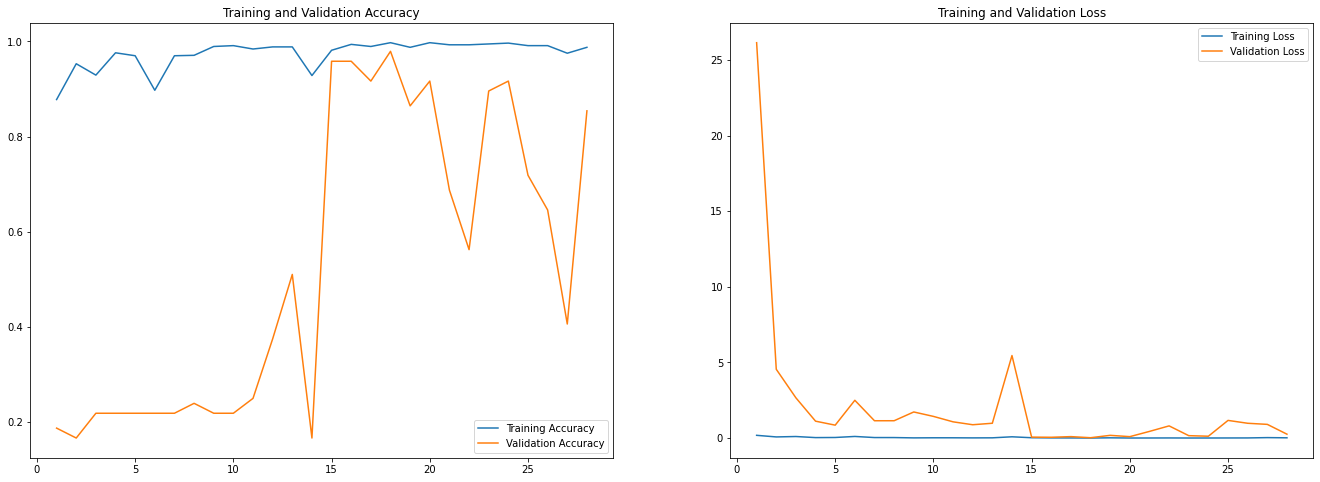

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
print("Evaluate on test data")
results = model_ResNet50.evaluate(test_generator)
print("test loss, test acc:", results)

Evaluate on test data
209/209 [==============================] - 17s 82ms/step - loss: 0.0623 - accuracy: 0.9378
test loss, test acc: [0.06234278529882431, 0.9377990365028381]


In [52]:
print("Evaluate on test data")
results = model_ResNet50.evaluate(test_generator)
print("test loss, test acc:", results)



Evaluate on test data
209/209 [==============================] - 18s 85ms/step - loss: 0.0623 - accuracy: 0.9378
test loss, test acc: [0.06234278529882431, 0.9377990365028381]


In [53]:
# Try to make confusion matrix 

pred= model_ResNet50.predict(test_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels=(test_generator.class_indices)
labels2=dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print(labels)
print(predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 1 4 4 0 4 4 4 0
 0 0 4 4 4 4 4 4 0 4 4 0 0 4 4 0 1 4 4 4 4 4 4 4]
{'biomaterial': 0, 'bone_marrow': 1, 'bone_with_osteocytes': 2, 'bone_without_osteocytes': 3, 'tissue_fibrous': 4}
['biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'bone_with_osteocytes', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 'biomaterial', 

In [41]:
predictions = model_ResNet50.predict(test_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
print(predictions)
print(predicted_classes )

209/209 [==============================] - 16s 77ms/step
[[9.9999976e-01 7.2652057e-08 5.4412190e-09 1.0423098e-07 4.8406676e-08]
 [9.9999988e-01 5.4196470e-08 9.3566115e-09 5.7540081e-08 4.9255892e-08]
 [9.9997830e-01 3.9593110e-06 5.4252964e-06 1.5770499e-06 1.0735205e-05]
 ...
 [3.7979567e-11 7.3569031e-09 3.5278423e-12 4.3075252e-11 1.0000000e+00]
 [2.5552038e-07 5.3884719e-07 5.7462870e-07 1.5306159e-07 9.9999845e-01]
 [4.7224447e-09 6.6915152e-07 1.7563590e-08 1.8260458e-08 9.9999928e-01]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 1 4 4 0 4 4 4 0
 0 0 4 4 4 4 4 4 0 4 4 0 0 4 4 0 1 4 4 4 4 4 4 4]


In [54]:
# Get ground-truth classes and class-labels
true_classes = test_generator.classes
print(true_classes)
class_labels = list(test_generator.class_indices.keys())  

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [55]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
report = classification_report(true_classes, predicted_class_indices, target_names=class_labels)
print(report)  
    

                         precision    recall  f1-score   support

            biomaterial       0.84      0.98      0.91        55
            bone_marrow       0.82      1.00      0.90         9
   bone_with_osteocytes       0.98      1.00      0.99        43
bone_without_osteocytes       1.00      1.00      1.00        55
         tissue_fibrous       1.00      0.74      0.85        47

               accuracy                           0.94       209
              macro avg       0.93      0.95      0.93       209
           weighted avg       0.95      0.94      0.94       209



In [56]:
#Y_pred = model_VGG16.predict_generator(test_generator)
#y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
cf_matrix = confusion_matrix(true_classes, predicted_class_indices)
print(cf_matrix)

Confusion Matrix
[[54  0  1  0  0]
 [ 0  9  0  0  0]
 [ 0  0 43  0  0]
 [ 0  0  0 55  0]
 [10  2  0  0 35]]


In [45]:
# reference: stackoverflow 
# https://stackoverflow.com/a/50386871

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

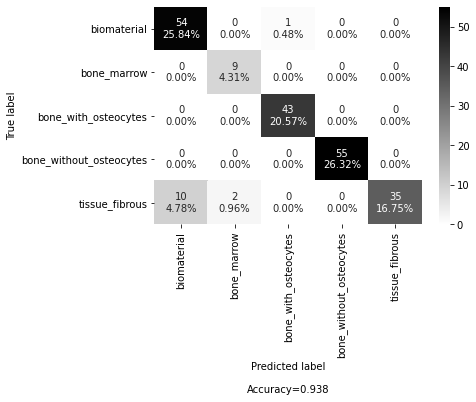

In [46]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['biomaterial', 'bone_marrow', 'bone_with_osteocytes', 'bone_without_osteocytes', 'tissue_fibrous']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')


In [47]:
from keras.preprocessing.image import ImageDataGenerator, load_img

def predict_image(filename):
    img = load_img(filename, target_size=(224, 224))
    image = keras.preprocessing.image.img_to_array(img)
    image = image / 255.0
    image = image.reshape(1,224,224,3)
    model = tf.keras.models.load_model('custom_model1.h5py')
    prediction = model.predict(image)
    print(prediction)
    plt.imshow(img)

    biomaterial_stat = prediction[0][0] * 100
    bonemarrow_stat = prediction[0][1] * 100
    bone_with_osteocytes_stat = prediction[0][2] * 100
    bone_without_osteocytes_stat = prediction[0][3] * 100
    tissue_fibrous_stat = prediction[0][4] * 100
    print("This image is %.2f percent %s"% (biomaterial_stat, "biomaterial\n"), 
          "This image is %.2f percent %s"% (bonemarrow_stat, "bone marrow\n"),
          "This image is %.2f percent %s"% (bone_with_osteocytes_stat, "bone_with_osteocytes\n"),
          "This image is %.2f percent %s"% (bone_without_osteocytes_stat, "bone_without_osteocytes\n"), 
          "This image is %.2f percent %s"% (tissue_fibrous_stat, "tissue_fibrous"))
   


[[0.16581412 0.10694274 0.07672755 0.4919713  0.1585443 ]]
This image is 16.58 percent biomaterial
 This image is 10.69 percent bone marrow
 This image is 7.67 percent bone_with_osteocytes
 This image is 49.20 percent bone_without_osteocytes
 This image is 15.85 percent tissue_fibrous


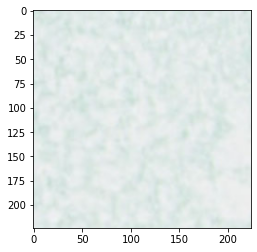

In [48]:
predict_image("/content/Bone_parts/test/biomaterial/1-8 1.tif")


In [49]:
predict_image("/content/Image_full_sized.jpg")

FileNotFoundError: ignored

In [ ]:
predict_image("/content/image_full_sized4.jpg")